In [1]:
import pandas as pd
import numpy as np
import pickle

import xgboost as xg

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import utils

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
data = pd.read_csv('../data/chi_df_cleaned.csv')
data.head()

,severity,start_lat,start_lng,end_lat,end_lng,distance(mi),number,temperature(f),wind_chill(f),humidity(%),pressure(in),visibility(mi),wind_speed(mph),precipitation(in),amenity,bump,crossing,give_way,junction,no_exit,railway,roundabout,station,stop,traffic_calming,traffic_signal,turning_loop,year,month,week,start_time_ep,end_time_ep,weather_timestamp_ep,accident_duration,side_R,side_nan,wind_direction_Calm,wind_direction_E,wind_direction_ENE,wind_direction_ESE,wind_direction_East,wind_direction_N,wind_direction_NE,wind_direction_NNE,wind_direction_NNW,wind_direction_NW,wind_direction_North,wind_direction_S,wind_direction_SE,wind_direction_SSE,wind_direction_SSW,wind_direction_SW,wind_direction_South,wind_direction_VAR,wind_direction_Variable,wind_direction_W,wind_direction_WNW,wind_direction_WSW,wind_direction_West,wind_direction_nan,weather_condition_Clear,weather_condition_Cloudy,weather_condition_Cloudy / Windy,weather_condition_Drizzle,weather_condition_Fair,weather_condition_Fair / Windy,weather_condition_Fog,weather_condition_Freezing Rain,weather_condition_Haze,weather_condition_Heavy Drizzle,weather_condition_Heavy Rain,weather_condition_Heavy Rain / Windy,weather_condition_Heavy Snow,weather_condition_Heavy T-Storm,weather_condition_Heavy T-Storm / Windy,weather_condition_Heavy Thunderstorms and Rain,weather_condition_Light Drizzle,weather_condition_Light Drizzle / Windy,weather_condition_Light Freezing Drizzle,weather_condition_Light Freezing Fog,weather_condition_Light Freezing Rain,weather_condition_Light Freezing Rain / Windy,weather_condition_Light Ice Pellets,weather_condition_Light Rain,weather_condition_Light Rain / Windy,weather_condition_Light Rain Showers,weather_condition_Light Rain with Thunder,weather_condition_Light Snow,weather_condition_Light Snow / Windy,weather_condition_Light Snow and Sleet / Windy,weather_condition_Light Thunderstorms and Rain,weather_condition_Light Thunderstorms and Snow,weather_condition_Mist,weather_condition_Mostly Cloudy,weather_condition_Mostly Cloudy / Windy,weather_condition_N/A Precipitation,weather_condition_Overcast,weather_condition_Partly Cloudy,weather_condition_Partly Cloudy / Windy,weather_condition_Patches of Fog,weather_condition_Rain,weather_condition_Rain / Windy,weather_condition_Scattered Clouds,weather_condition_Smoke,weather_condition_Snow,weather_condition_Snow / Windy,weather_condition_Squalls,weather_condition_Squalls / Windy,weather_condition_T-Storm,weather_condition_T-Storm / Windy,weather_condition_Thunder,weather_condition_Thunder in the Vicinity,weather_condition_Thunderstorm,weather_condition_Thunderstorms and Rain,weather_condition_Wintry Mix,weather_condition_Wintry Mix / Windy,weather_condition_nan,sunrise_sunset_Night,sunrise_sunset_nan,civil_twilight_Night,civil_twilight_nan,nautical_twilight_Night,nautical_twilight_nan,astronomical_twilight_Night,astronomical_twilight_nan,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,day_nan,hour_01,hour_02,hour_03,hour_04,hour_05,hour_06,hour_07,hour_08,hour_09,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_nan
0,2,42.305960,-87.960150,42.306916,-87.960918,0.077,0.0,37.0,31.0,79.0,29.59,10.0,8.1,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,2016,11,48,1.480517e+09,1.480539e+09,1.480518e+09,21600.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,42.175870,-88.135770,42.174620,-88.135794,0.086,21500.0,37.0,28.1,76.0,29.62,10.0,15.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,2016,11,48,1.480518e+09,1.480540e+09,1.480518e+09,21600.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0

In [4]:
wind_directions = ['wind_direction_Calm','wind_direction_E','wind_direction_ENE','wind_direction_ESE','wind_direction_East','wind_direction_N','wind_direction_NE','wind_direction_NNE',
 'wind_direction_NNW','wind_direction_NW','wind_direction_North','wind_direction_S','wind_direction_SE','wind_direction_SSE','wind_direction_SSW','wind_direction_SW',
 'wind_direction_South','wind_direction_VAR','wind_direction_Variable','wind_direction_W','wind_direction_WNW','wind_direction_WSW','wind_direction_West','wind_direction_nan']
for direction in wind_directions:
    data[direction] = data[direction] * data['wind_speed(mph)']

In [5]:
X = data.drop(['severity','number','accident_duration','weather_timestamp_ep','end_time_ep','distance(mi)','end_lng','end_lat','year',
               'amenity','bump','crossing','give_way','junction','no_exit','railway','roundabout','station','stop','traffic_calming','traffic_signal','turning_loop','side_R','side_nan',
               'day_nan','hour_nan','weather_condition_nan','sunrise_sunset_nan','civil_twilight_nan','nautical_twilight_nan','astronomical_twilight_nan','wind_speed(mph)'], axis=1)
y = data['severity']

In [6]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [7]:
X_train.head()

,start_lat,start_lng,temperature(f),wind_chill(f),humidity(%),pressure(in),visibility(mi),precipitation(in),month,week,start_time_ep,wind_direction_Calm,wind_direction_E,wind_direction_ENE,wind_direction_ESE,wind_direction_East,wind_direction_N,wind_direction_NE,wind_direction_NNE,wind_direction_NNW,wind_direction_NW,wind_direction_North,wind_direction_S,wind_direction_SE,wind_direction_SSE,wind_direction_SSW,wind_direction_SW,wind_direction_South,wind_direction_VAR,wind_direction_Variable,wind_direction_W,wind_direction_WNW,wind_direction_WSW,wind_direction_West,wind_direction_nan,weather_condition_Clear,weather_condition_Cloudy,weather_condition_Cloudy / Windy,weather_condition_Drizzle,weather_condition_Fair,weather_condition_Fair / Windy,weather_condition_Fog,weather_condition_Freezing Rain,weather_condition_Haze,weather_condition_Heavy Drizzle,weather_condition_Heavy Rain,weather_condition_Heavy Rain / Windy,weather_condition_Heavy Snow,weather_condition_Heavy T-Storm,weather_condition_Heavy T-Storm / Windy,weather_condition_Heavy Thunderstorms and Rain,weather_condition_Light Drizzle,weather_condition_Light Drizzle / Windy,weather_condition_Light Freezing Drizzle,weather_condition_Light Freezing Fog,weather_condition_Light Freezing Rain,weather_condition_Light Freezing Rain / Windy,weather_condition_Light Ice Pellets,weather_condition_Light Rain,weather_condition_Light Rain / Windy,weather_condition_Light Rain Showers,weather_condition_Light Rain with Thunder,weather_condition_Light Snow,weather_condition_Light Snow / Windy,weather_condition_Light Snow and Sleet / Windy,weather_condition_Light Thunderstorms and Rain,weather_condition_Light Thunderstorms and Snow,weather_condition_Mist,weather_condition_Mostly Cloudy,weather_condition_Mostly Cloudy / Windy,weather_condition_N/A Precipitation,weather_condition_Overcast,weather_condition_Partly Cloudy,weather_condition_Partly Cloudy / Windy,weather_condition_Patches of Fog,weather_condition_Rain,weather_condition_Rain / Windy,weather_condition_Scattered Clouds,weather_condition_Smoke,weather_condition_Snow,weather_condition_Snow / Windy,weather_condition_Squalls,weather_condition_Squalls / Windy,weather_condition_T-Storm,weather_condition_T-Storm / Windy,weather_condition_Thunder,weather_condition_Thunder in the Vicinity,weather_condition_Thunderstorm,weather_condition_Thunderstorms and Rain,weather_condition_Wintry Mix,weather_condition_Wintry Mix / Windy,sunrise_sunset_Night,civil_twilight_Night,nautical_twilight_Night,astronomical_twilight_Night,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,hour_01,hour_02,hour_03,hour_04,hour_05,hour_06,hour_07,hour_08,hour_09,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
16501,41.75120,-88.01272,80.0,80.0,67.0,29.16,10.0,0.00,5,21,1.590592e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
30371,41.88773,-87.76512,73.0,73.0,84.0,29.91,10.0,0.00,8,31,1.533675e+09,0.0,0.0,0.0,0.0,6.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
10485,41.98944,-88.14605,25.0,12.2,46.0,30.35,10.0,0.00,3,11,1.489513e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6748,41.57825,-87.66069,68.0,68.0,81.0,30.20,10.0,0.00,9,35,1.472777e+09,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [32]:
X['wind_direction_Calm'].value_counts()

0.000000     39247
10.003125     1607
Name: wind_direction_Calm, dtype: int64

In [8]:
X_test.head()

,start_lat,start_lng,temperature(f),wind_chill(f),humidity(%),pressure(in),visibility(mi),precipitation(in),month,week,start_time_ep,wind_direction_Calm,wind_direction_E,wind_direction_ENE,wind_direction_ESE,wind_direction_East,wind_direction_N,wind_direction_NE,wind_direction_NNE,wind_direction_NNW,wind_direction_NW,wind_direction_North,wind_direction_S,wind_direction_SE,wind_direction_SSE,wind_direction_SSW,wind_direction_SW,wind_direction_South,wind_direction_VAR,wind_direction_Variable,wind_direction_W,wind_direction_WNW,wind_direction_WSW,wind_direction_West,wind_direction_nan,weather_condition_Clear,weather_condition_Cloudy,weather_condition_Cloudy / Windy,weather_condition_Drizzle,weather_condition_Fair,weather_condition_Fair / Windy,weather_condition_Fog,weather_condition_Freezing Rain,weather_condition_Haze,weather_condition_Heavy Drizzle,weather_condition_Heavy Rain,weather_condition_Heavy Rain / Windy,weather_condition_Heavy Snow,weather_condition_Heavy T-Storm,weather_condition_Heavy T-Storm / Windy,weather_condition_Heavy Thunderstorms and Rain,weather_condition_Light Drizzle,weather_condition_Light Drizzle / Windy,weather_condition_Light Freezing Drizzle,weather_condition_Light Freezing Fog,weather_condition_Light Freezing Rain,weather_condition_Light Freezing Rain / Windy,weather_condition_Light Ice Pellets,weather_condition_Light Rain,weather_condition_Light Rain / Windy,weather_condition_Light Rain Showers,weather_condition_Light Rain with Thunder,weather_condition_Light Snow,weather_condition_Light Snow / Windy,weather_condition_Light Snow and Sleet / Windy,weather_condition_Light Thunderstorms and Rain,weather_condition_Light Thunderstorms and Snow,weather_condition_Mist,weather_condition_Mostly Cloudy,weather_condition_Mostly Cloudy / Windy,weather_condition_N/A Precipitation,weather_condition_Overcast,weather_condition_Partly Cloudy,weather_condition_Partly Cloudy / Windy,weather_condition_Patches of Fog,weather_condition_Rain,weather_condition_Rain / Windy,weather_condition_Scattered Clouds,weather_condition_Smoke,weather_condition_Snow,weather_condition_Snow / Windy,weather_condition_Squalls,weather_condition_Squalls / Windy,weather_condition_T-Storm,weather_condition_T-Storm / Windy,weather_condition_Thunder,weather_condition_Thunder in the Vicinity,weather_condition_Thunderstorm,weather_condition_Thunderstorms and Rain,weather_condition_Wintry Mix,weather_condition_Wintry Mix / Windy,sunrise_sunset_Night,civil_twilight_Night,nautical_twilight_Night,astronomical_twilight_Night,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,hour_01,hour_02,hour_03,hour_04,hour_05,hour_06,hour_07,hour_08,hour_09,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
26982,42.015450,-87.790940,18.0,4.8,81.0,30.53,9.0,0.0,2,8,1.551174e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37893,41.797620,-87.631450,62.1,62.1,78.0,30.02,10.0,0.0,8,34,1.503544e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26817,42.058838,-88.322168,26.1,16.8,75.0,30.35,10.0,0.0,2,7,1.550486e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
24950,42.429020,-87.945870,51.0,51.0,74.0,29.11,10.0,0.0,10,42,1.571852e+09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [9]:
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)

X_train shape: (30640, 124)
y_train shape: (30640,)
X_test shape: (10214, 124)
y_test shape: (10214,)


In [10]:
y.value_counts(normalize=True)

3    0.507049
2    0.413032
4    0.073873
1    0.006046
Name: severity, dtype: float64

In [11]:
xg_model = xg.sklearn.XGBClassifier()
xg_model.fit(X_train,y_train);

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:52:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [12]:
# print out our accuracy scores
print('XGBoost Training Accuracy:', xg_model.score(X_train,y_train))
print('XGBoost Testing Accuracy:', xg_model.score(X_test,y_test))

XGBoost Training Accuracy: 0.8825391644908617
XGBoost Testing Accuracy: 0.8291560603093793


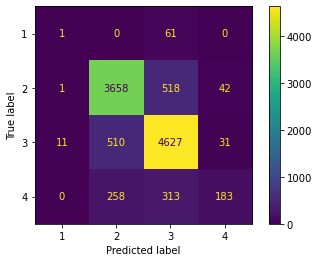

In [13]:
plot_confusion_matrix(xg_model, X_test, y_test)

In [14]:
xg_preds = xg_model.predict(X_test)

In [15]:
pd.DataFrame(xg_preds).value_counts(normalize=True)

3    0.540337
2    0.433327
4    0.025064
1    0.001273
dtype: float64

In [16]:
f1_score(y_test,xg_preds,average='weighted')

0.8150815024767646

In [17]:
#save the model
with open('./models/xgboost.pkl', mode='wb') as pickle_out:
    pickle.dump(xg_model, pickle_out)

In [18]:
# decision tree model with just a few hyperparameters
tree = DecisionTreeClassifier(max_depth=8, min_samples_split=5)
tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=8, min_samples_split=5)

In [19]:
print('Decision Tree Training Accuracy:', tree.score(X_train,y_train))
print('Decision Tree Testing Accuracy:', tree.score(X_test,y_test))

Decision Tree Training Accuracy: 0.8011096605744126
Decision Tree Testing Accuracy: 0.7884276483258273


In [20]:
tree_coefs = pd.DataFrame(zip(X_train.columns, tree.feature_importances_), columns=['feature','coefficient'])
tree_coefs[tree_coefs['coefficient'] > 0].sort_values(by='coefficient', ascending=False)

,feature,coefficient
10,start_time_ep,0.318378
92,civil_twilight_Night,0.116338
117,hour_17,0.099965
115,hour_15,0.098574
118,hour_18,0.096167
116,hour_16,0.094148
119,hour_19,0.034335
106,hour_06,0.025475
9,week,0.025056
1,start_lng,0.017849


In [21]:
forrest = RandomForestClassifier(max_depth=10)
forrest.fit(X_train,y_train)

RandomForestClassifier(max_depth=10)

In [22]:
print('Random Forrest Training Accuracy:', forrest.score(X_train,y_train))
print('Random Forrest Testing Accuracy:', forrest.score(X_test,y_test))

Random Forrest Training Accuracy: 0.7906657963446475
Random Forrest Testing Accuracy: 0.7810847855884081


In [23]:
bag = BaggingClassifier()
bag.fit(X_train,y_train)

BaggingClassifier()

In [24]:
print('BAG Training Accuracy:', bag.score(X_train,y_train))
print('BAG Testing Accuracy:', bag.score(X_test,y_test))

BAG Training Accuracy: 0.9863250652741514
BAG Testing Accuracy: 0.8273937732523987


In [25]:
with open('./models/BAG.pkl', mode='wb') as pickle_out:
    pickle.dump(bag, pickle_out)

In [26]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [27]:
y_train_cat = utils.to_categorical(y_train-1, 4)
y_test_cat = utils.to_categorical(y_test-1, 4)

In [28]:
y_test_cat

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [29]:
nn = Sequential()

nn.add(
    Dense(
        128,
        activation = 'relu'
    )
)

nn.add(Dropout(.4))

nn.add(
    Dense(
        64,
        activation = 'relu'
    )
)

nn.add(Dropout(.3))

nn.add(
    Dense(
        32,
        activation = 'relu'
    )
)

nn.add(Dropout(.2))

nn.add(
    Dense(
        16,
        activation = 'relu'
    )
)

nn.add(Dropout(.1))

nn.add(
    Dense(
        8,
        activation = 'relu'
    )
)

nn.add(
    Dense(
        4,
        activation = 'softmax'
    )
)

nn.compile(
    loss='categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [30]:
history = nn.fit(
    X_train_sc, 
    y_train_cat,
    validation_data=(X_test_sc, y_test_cat),
    epochs = 256,
    verbose = 0
)

In [31]:
max(history.history['accuracy']),max(history.history['val_accuracy'])

(0.8338119983673096, 0.8091834783554077)

In [37]:
nn.save('./models/neural_net')

INFO:tensorflow:Assets written to: ./models/neural_net\assets
